In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import ternary

In [4]:
import scipy.stats

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [6]:
import sklearn.preprocessing
import sklearn.model_selection

In [7]:
import uproot
uproot.default_library = "np"

In [8]:
import os.path

In [9]:
import logging
logging.basicConfig(level=logging.INFO)

In [10]:
np.set_printoptions(precision=4, suppress=True)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data

In [12]:
raw_names = [
    "data/sim09g_KJpsi_2017MD_folded.root:DecayTree;1",
    "data/sim09g_KJpsi_mumu2017MD.root:B2XMuMu_Line_Tuple/DecayTree;266",
    "data/sim09g_Kee_2017MD_folded.root:DecayTree;1",
    "data/sim09g_Kmumu_2017MD.root:B2XMuMu_Line_Tuple/DecayTree;2",
    
    "DLA/KPsi2See_2018_MD_folded.root:DecayTree;1",
    "DLA/KPsi2S_mumu_2018MD_folded.root:DecayTree;1",

    "DLA/sim09h_Dplus_PhiPi_2018_MD_folded.root:DecayTree;1",
    "DLA/sim09h_Dplus_PhiPi_mumu_2018_MD_folded.root:DecayTree;1",
]

In [13]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

### Truthing

In [14]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_GeV > %g" % v1, "q2_GeV < %g" % v2)

In [15]:
aliases = {
    #"BM":     "sqrt(B_plus_TRUEP_E**2-B_plus_TRUEPT**2-B_plus_TRUEP_Z**2)",
    "ll_E":   "e_plus_TRUEP_E + e_minus_TRUEP_E",
    "ll_X":   "e_plus_TRUEP_X + e_minus_TRUEP_X",
    "ll_Y":   "e_plus_TRUEP_Y + e_minus_TRUEP_Y",
    "ll_Z":   "e_plus_TRUEP_Z + e_minus_TRUEP_Z",
    "ll_M2":  "ll_E**2 - ll_X**2 - ll_Y**2 - ll_Z**2",
    #"JM":     "J_psi_1S_M_TRUE",
    #"BM":     "B_plus_M_TRUE",
    #"q2_" :   "J_psi_1S_TRUEP_E**2-J_psi_1S_TRUEPT**2-J_psi_1S_TRUEP_Z**2",
    #"q":      "J_psi_1S_M",
    #"q2":     "q**2",
    "q2":     "ll_M2",
    "q2_GeV": "q2*1e-6",
    "ep_p2":  "e_plus_TRUEPT**2+e_plus_TRUEP_Z**2",
    "em_p2":  "e_minus_TRUEPT**2+e_minus_TRUEP_Z**2",
    "ep_p":   "sqrt(ep_p2)",
    "em_p":   "sqrt(em_p2)",
    "min_pl": "fmin(ep_p, em_p)",
    "max_pl": "fmax(ep_p, em_p)",
    "ppcos_ll":  "e_plus_TRUEP_X*e_minus_TRUEP_X + e_plus_TRUEP_Y*e_minus_TRUEP_Y + e_plus_TRUEP_Z*e_minus_TRUEP_Z",
    "cos_ll":    "ppcos_ll/(ep_p*em_p)",
    "alpha":  "acos(cos_ll)",
    "log_max_pl": "log(max_pl)",
}

In [16]:
features = [
    #"e_minus_TRUEPT",
    #"e_plus_TRUEPT",
    "log_max_pl",
    "alpha",
]

In [17]:
# https://arxiv.org/abs/2103.11769
#
q_Kll_selector = q2_range(1.1, 6.0)
#
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
D_selector = "abs(D_plus_TRUEID)==411"
phi_selector = "abs(Phi_TRUEID)==333"
pi_selector = "abs(Pi_TRUEID)==211"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
Dphipi_selector = join_and(D_selector, phi_selector, pi_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)
Dphipi_ee_selector =  join_and(e_selector, Dphipi_selector)
Dphipi_mumu_selector = join_and(mu_selector, Dphipi_selector)

In [18]:
selectors = [
    Je_selector,
    Jmu_selector,
    Kee_selector,
    Kmumu_selector,
    psi2Se_selector,
    psi2Smu_selector,
    Dphipi_ee_selector,
    Dphipi_mumu_selector,
]
selectors

['((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2_GeV > 6)&(q2_GeV < 12.96))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2_GeV > 8.68)&(q2_GeV < 10.09))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2_GeV > 1.1)&(q2_GeV < 6)))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2_GeV > 1.1)&(q2_GeV < 6)))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2_GeV > 9.82)&(q2_GeV < 16.4))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2_GeV > 12.5)&(q2_GeV < 14.2))',
 '((abs(e_minus_TRUEID)==11

In [19]:
truthed = [f.arrays(features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>

In [20]:
df_index = [
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺J/ψ(→µµ)",
    r"B⁺→K⁺ee",
    r"B⁺→K⁺µµ",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"B⁺→K⁺ψ(2S)(→µµ)",
    r"D⁺→π⁺φ(→ee)",
    r"D⁺→π⁺φ(→µµ)",
]
df = pd.DataFrame(index=df_index)

In [21]:
df["Total"] = [f["e_minus_TRUEID"].array(library="np").shape[0] for f in raw_files]
df["N"] = [b[features[0]].shape[0] for b in truthed]
df["N/Total"] = df["N"]/df["Total"]
df

Total        N   N/Total
B⁺→K⁺J/ψ(→ee)    2084124   731925  0.351191
B⁺→K⁺J/ψ(→µµ)    3206889  1460434  0.455405
B⁺→K⁺ee           413741    36689  0.088676
B⁺→K⁺µµ           665455    72527  0.108989
B⁺→K⁺ψ(2S)(→ee)   869415   247181  0.284307
B⁺→K⁺ψ(2S)(→µµ)  2313029  1039105  0.449240
D⁺→π⁺φ(→ee)       499520   149292  0.298871
D⁺→π⁺φ(→µµ)       678441   312775  0.461020

$$\begin{aligned}
R_K&=\frac{\mathcal{B}(B\to K\mu\mu)}{\mathcal{B}(B \to Kee)} \Big/ \frac{\mathcal{B}(B\to KJ/\psi(\to \mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
, \\
R_{\psi(2S)}&=\frac{\mathcal{B}(B\to K\psi(2S)(\to\mu\mu))}{\mathcal{B}(B \to K\psi(2S)(\to ee))} \Big/ \frac{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
, \\
r_{J/\psi}&=\frac{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
.
\end{aligned}$$

In [22]:
def r_K(a): return a[3]/a[2]
def r_Jpsi(a): return a[1]/a[0]
def r_psi2S(a): return a[5]/a[4]
def R_K(a): return r_K(a)/r_Jpsi(a)
def R_psi2S(a): return r_psi2S(a)/r_Jpsi(a)

def double_ratio(a): return R_K(a)
def double_ratio_psi2S(a): return R_psi2S(a)

### Graphs

In [23]:
for idx in [0, 2, 4, 6]:
    plt.hist(truthed[idx]['alpha'], label="e- %s"%df_index[idx],
             density=True, bins=np.linspace(0, 1.0, 101), histtype='step')
plt.title('alpha(l,l)')
plt.legend()
plt.show()

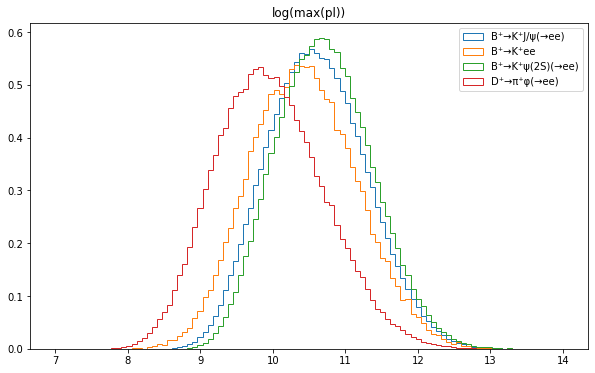

In [24]:
for idx in [0, 2, 4, 6]:
    data = truthed[idx]
    plt.hist(data['log_max_pl'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(7, 14, 101), histtype='step')
plt.title(r'log(max(pl))')
plt.legend()
plt.show()

### Preprocessing

In [25]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [26]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    mapping = dict()
    for i, ix in enumerate(idx):
        x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
        mapping[i] = ix
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y, mapping

In [27]:
X, Y, mapping = make_dataset(["alpha", "log_max_pl"], [0,2,4,6])
X.shape, Y.shape, mapping

((1165087, 2), (1165087,), {0: 0, 1: 2, 2: 4, 3: 6})

In [28]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)

In [29]:
y_train.mean(), y_test.mean()

(0.840218848764708, 0.8402097692023792)

In [30]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)

StandardScaler()

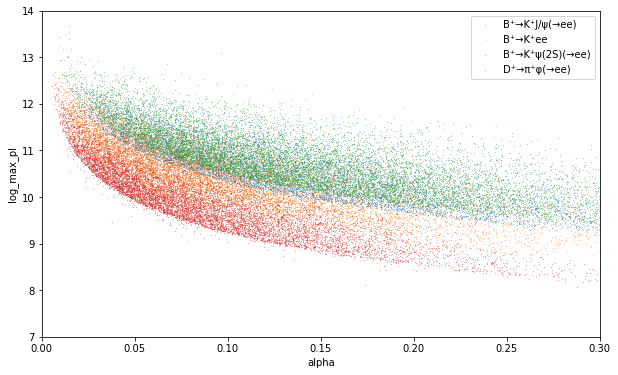

In [31]:
for label in [0,1,2,3]:
    idx = y_train==label
    x = x_train[idx][:10000]
    plt.scatter(*(x.T), marker=".", s=0.1, label="%s"%df_index[mapping[label]])
#plt.gca().set_aspect('equal')
plt.xlim(0,0.3)
plt.ylim(7,14)
plt.xlabel("alpha")
plt.ylabel("log_max_pl")
plt.plot()
plt.legend()
plt.show()

In [32]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [36]:
def get_random_samples(data, size=1000):
    index = torch.randint(len(data), size=(size,), device=device)
    return data[index]

In [58]:
# dataset is a dict of datasets
class EqualSizeLoader(object):
    def __init__(self, dataset, shape, batch_size=1, batch_number=1, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.batch_number = batch_number
        self.device = device
        self.labels = sorted(dataset.keys())
        self.shape = shape
    def __len__(self):
        return self.batch_num
    def __iter__(self):
        for i in range(0, self.batch_number):
            batch = torch.zeros(self.batch_size, len(self.labels), *self.shape, device=device)
            for i, label in enumerate(self.labels):
                index = torch.randint(len(self.dataset[label]), size=(self.batch_size,), device=device)
                batch[:,i] = self.dataset[label][index][0]
            yield batch

In [59]:
split_dataset = {label: torch.utils.data.TensorDataset(from_numpy(scaler.transform(x_train[y_train==label]))) for label in [0,1,2,3]}
split_loader = EqualSizeLoader(split_dataset, [2], batch_size=1024*8, batch_number=20, device=device)

In [33]:
dataset = torch.utils.data.TensorDataset(
    from_numpy(scaler.transform(x_train)),
    from_numpy(y_train, dtype=torch.long)
)
#loader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=True)
loader = Loader(dataset, batch_size=10000, shuffle=True, device=device)
len(dataset), len(loader)

(1048578, 105)

In [34]:
counts = np.asarray([np.sum(y_train==label) for label in sorted(mapping.keys())])
counts

array([658732,  33020, 222463, 134363])

In [35]:
weights = y_train.shape[0]/counts/counts.shape[0]
weights

array([0.398 , 7.939 , 1.1784, 1.951 ])

### NN

In [37]:
def model(inputs=2, outputs=4):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [38]:
def train(model, loader, epochs=20, weight=None):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
            )
            opt.zero_grad()
            loss.backward()
            opt.step()
        logging.info("Epoch %d, %f", epoch, loss)
    model.eval()

In [39]:
m = model().to(device)

In [40]:
%%time
train(m, loader, epochs=50, weight=weights)

INFO:root:Epoch 0, 1.118237
INFO:root:Epoch 1, 0.904927
INFO:root:Epoch 2, 0.838102
INFO:root:Epoch 3, 0.826149
INFO:root:Epoch 4, 0.812363
INFO:root:Epoch 5, 0.821401
INFO:root:Epoch 6, 0.822402
INFO:root:Epoch 7, 0.794675
INFO:root:Epoch 8, 0.818372
INFO:root:Epoch 9, 0.790384
INFO:root:Epoch 10, 0.789375
INFO:root:Epoch 11, 0.787602
INFO:root:Epoch 12, 0.772464
INFO:root:Epoch 13, 0.762754
INFO:root:Epoch 14, 0.784756
INFO:root:Epoch 15, 0.777247
INFO:root:Epoch 16, 0.793403
INFO:root:Epoch 17, 0.798604
INFO:root:Epoch 18, 0.754809
INFO:root:Epoch 19, 0.779679
INFO:root:Epoch 20, 0.801432
INFO:root:Epoch 21, 0.788867
INFO:root:Epoch 22, 0.779174
INFO:root:Epoch 23, 0.793429
INFO:root:Epoch 24, 0.792228
INFO:root:Epoch 25, 0.783500
INFO:root:Epoch 26, 0.778462
INFO:root:Epoch 27, 0.802277
INFO:root:Epoch 28, 0.775139
INFO:root:Epoch 29, 0.803883
INFO:root:Epoch 30, 0.764911
INFO:root:Epoch 31, 0.773545
INFO:root:Epoch 32, 0.764308
INFO:root:Epoch 33, 0.794030
INFO:root:Epoch 34, 0.77

CPU times: user 20.8 s, sys: 353 ms, total: 21.2 s
Wall time: 21.1 s


In [41]:
m.eval()

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [117]:
def plot_field(f, name=None, save=None):
    x_min = 0.0
    x_max = 0.3
    y_min = 7
    y_max = 14
    X_test = np.random.rand(3000000, 2) * [x_max-x_min, y_max-y_min] + [x_min, y_min]
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=1.0, vmin=0.0)
    plt.colorbar()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("alpha")
    plt.ylabel("log_max_pl")
    #plt.gca().set_aspect('equal')
    if name is not None:
        plt.title(name)
    if save is not None:
        plt.savefig(save)
    plt.show()

In [43]:
def plot_clf(clf,c0,c1):
    fn = lambda x : x[:,c1] - x[:,c0]
    f = lambda x : to_numpy(torch.sigmoid(fn(clf(from_numpy(scaler.transform(x))))))
    plot_field(f,r'$\sigma\left(\log\frac{p(%s|x)}{p(%s|x)}\right)$'%(mapping[c1],mapping[c0]))

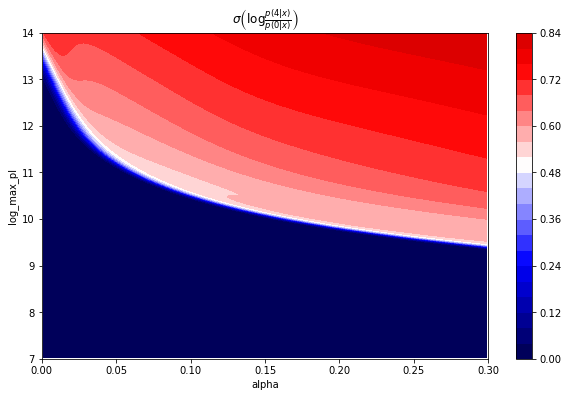

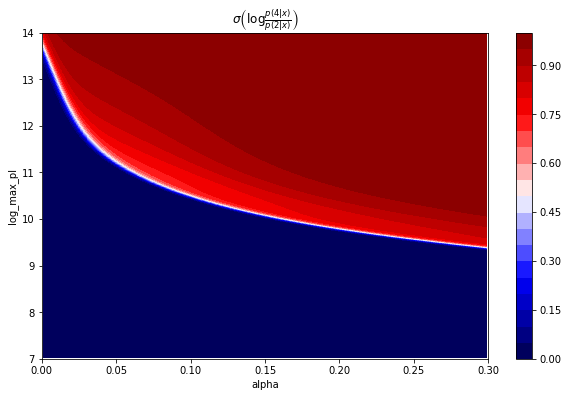

In [44]:
plot_clf(m,0,1)
plot_clf(m,0,2)
plot_clf(m,1,2)

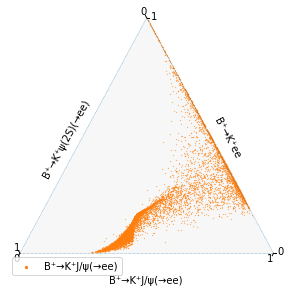

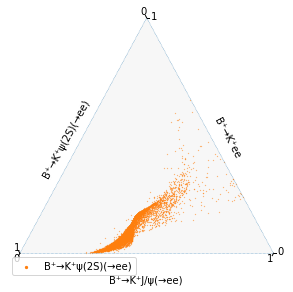

In [170]:
for label in [0,1,2]:
    fig, tax = ternary.figure(scale=1.0)
    fig.set_size_inches(5, 5)

    idx = y_train==label
    x = x_train[idx][:10000]
    v = to_numpy(torch.softmax(m(from_numpy(scaler.transform(x)))[:,0:3], dim=1))
    tax.scatter(v, marker=".", s=0.2, label="%s"%df_index[mapping[label]])
    
    tax.gridlines(multiple=20)
    tax.get_axes().axis('off')
    tax.left_axis_label(df_index[mapping[2]])
    tax.right_axis_label(df_index[mapping[1]])
    tax.bottom_axis_label(df_index[mapping[0]])
    plt.legend(markerscale=10)
    tax.ticks(axis='lbr', linewidth=1)
    plt.show()

### Weight limits estimation

$$\begin{aligned}
\inf_x\frac{p_1(x)}{p_0(x)}
\leq
\frac{\mathbb{E}_{x\sim p_1}[w(x)]}{\mathbb{E}_{x\sim p_0}[w(x)]}
\leq
\sup_x\frac{p_1(x)}{p_0(x)}
.
\end{aligned}$$

### Crafting a loss

In [146]:
def ratio_estimator(vec):
    m_minus = np.sum(np.maximum(-vec, 0))
    m_plus = np.sum(np.maximum(vec, 0))
    return 1/m_minus

In [144]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = torch.softmax(model(x), dim=1) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W

In [145]:
def train_pinv(model, loader, selected_class, epochs=50, alpha=0.001):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    n_outs = 4 # N
    n_classes = 4 # n
    for epoch in range(epochs):
        W = create_w(model, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        det = np.linalg.det(W_np)
        W_pinv_ = from_numpy(W_pinv)
        
        wcj = W_pinv[selected_class]
        wcj_ = (wcj<0)
        wki = np.sum(W_pinv*wcj_[None,:], axis=1)
        W_m = np.multiply.outer(wcj, wki)
        W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
        #print(pred.shape, W.shape, W_pinv.shape)
        #print(W_pinv, w1j, wki, W_m)
        #print(ratio_estimator(w1j))
        #loss = torch.sum(W*from_numpy(W_m_))
        loss_c = torch.sum(W*from_numpy(W_m_))
        loss_d = -torch.sum(W*(W_pinv_.T))
        loss = loss_d + alpha * loss_c
        opt.zero_grad()
        loss.backward()
        opt.step()
        #logging.info("Epoch %d, loss=%f est=%f", epoch, loss, ratio_estimator(W_pinv[selected_class]))
        print("Epoch %d, loss=%f est=%f" % (epoch, loss, ratio_estimator(W_pinv[selected_class])),
              W_pinv[selected_class],
              det)
        #raise NotImplementedError
    model.eval()

In [155]:
m_la = model().to(device)
m_la.load_state_dict(m.state_dict())

<All keys matched successfully>

In [156]:
%%time
# 1 for Kee
train_pinv(m_la, loader, 1, epochs=200, alpha=0.001)
train_pinv(m_la, loader, 1, epochs=500, alpha=300)

Epoch 0, loss=-4.000103 est=0.273391 [-2.4926  3.6689  1.1136 -1.1652] 0.013676009
Epoch 1, loss=-4.000099 est=0.297428 [-2.2842  3.6883  0.9383 -1.0779] 0.015175541
Epoch 2, loss=-4.000098 est=0.321559 [-2.0746  3.678   0.7798 -1.0353] 0.016678901
Epoch 3, loss=-4.000096 est=0.345453 [-1.8803  3.6491  0.6472 -1.0145] 0.018198114
Epoch 4, loss=-4.000095 est=0.368515 [-1.7064  3.604   0.5398 -1.0072] 0.01974156
Epoch 5, loss=-4.000094 est=0.390459 [-1.5524  3.5462  0.4531 -1.0087] 0.021311903
Epoch 6, loss=-4.000095 est=0.411081 [-1.4168  3.4801  0.3832 -1.0158] 0.022904208
Epoch 7, loss=-4.000096 est=0.430247 [-1.2981  3.41    0.3269 -1.0261] 0.024508465
Epoch 8, loss=-4.000097 est=0.447930 [-1.1949  3.3393  0.2814 -1.0376] 0.026111301
Epoch 9, loss=-4.000098 est=0.464265 [-1.1055  3.2714  0.2445 -1.0485] 0.027698888
Epoch 10, loss=-4.000099 est=0.479542 [-1.028   3.2085  0.2145 -1.0573] 0.029258475
Epoch 11, loss=-4.000100 est=0.494172 [-0.9607  3.1525  0.1897 -1.0629] 0.030780286
Epo

Epoch 100, loss=-4.000093 est=0.937171 [-0.1961  2.4323  0.0192 -0.871 ] 0.06497435
Epoch 101, loss=-4.000093 est=0.938601 [-0.1952  2.4308  0.0191 -0.8702] 0.06505245
Epoch 102, loss=-4.000093 est=0.940053 [-0.1943  2.4293  0.019  -0.8695] 0.06512908
Epoch 103, loss=-4.000093 est=0.941543 [-0.1934  2.4279  0.0189 -0.8687] 0.06520425
Epoch 104, loss=-4.000093 est=0.943071 [-0.1925  2.4267  0.0188 -0.8678] 0.06527799
Epoch 105, loss=-4.000093 est=0.944617 [-0.1917  2.4255  0.0188 -0.867 ] 0.065350376
Epoch 106, loss=-4.000093 est=0.946149 [-0.1908  2.4243  0.0187 -0.8661] 0.065421246
Epoch 107, loss=-4.000093 est=0.947638 [-0.19    2.4232  0.0186 -0.8653] 0.06549085
Epoch 108, loss=-4.000093 est=0.949055 [-0.1892  2.4221  0.0185 -0.8645] 0.06555902
Epoch 109, loss=-4.000093 est=0.950392 [-0.1884  2.4209  0.0184 -0.8638] 0.06562594
Epoch 110, loss=-4.000093 est=0.951650 [-0.1877  2.4196  0.0184 -0.8631] 0.06569145
Epoch 111, loss=-4.000093 est=0.952849 [-0.187   2.4184  0.0183 -0.8625] 0

Epoch 199, loss=-4.000092 est=1.014403 [-0.1551  2.3642  0.0152 -0.8307] 0.06882259
Epoch 0, loss=-31.502340 est=1.014848 [-0.1549  2.3638  0.0151 -0.8304] 0.06884375
Epoch 1, loss=-28.146643 est=1.121535 [-0.1642  2.4818  0.0174 -0.7274] 0.06844647
Epoch 2, loss=-25.304735 est=1.229596 [-0.1527  2.6129  0.0166 -0.6606] 0.0675083
Epoch 3, loss=-22.830671 est=1.338981 [-0.1374  2.7586  0.015  -0.6094] 0.06604856
Epoch 4, loss=-20.672804 est=1.446610 [-0.125   2.9227  0.0138 -0.5663] 0.06408512
Epoch 5, loss=-18.793921 est=1.550574 [-0.1168  3.1078  0.013  -0.5281] 0.061704047
Epoch 6, loss=-17.161179 est=1.649810 [-0.1118  3.3155  0.0126 -0.4943] 0.059021473
Epoch 7, loss=-15.745084 est=1.743662 [-0.1087  3.5457  0.0125 -0.4648] 0.056157824
Epoch 8, loss=-14.517472 est=1.831931 [-0.1066  3.7976  0.0125 -0.4393] 0.053221107
Epoch 9, loss=-13.451983 est=1.914699 [-0.1047  4.0703  0.0124 -0.4176] 0.05029492
Epoch 10, loss=-12.525669 est=1.992039 [-0.1027  4.3629  0.0123 -0.3993] 0.04743825

Epoch 97, loss=-7.614896 est=2.610641 [-0.0716  8.4296  0.0132 -0.3114] 0.025579436
Epoch 98, loss=-7.600085 est=2.613877 [-0.0716  8.4563  0.0132 -0.311 ] 0.02550235
Epoch 99, loss=-7.584670 est=2.617230 [-0.0715  8.4842  0.0132 -0.3106] 0.025422545
Epoch 100, loss=-7.568582 est=2.620714 [-0.0715  8.5135  0.0132 -0.3101] 0.025339697
Epoch 101, loss=-7.551723 est=2.624351 [-0.0714  8.5443  0.0132 -0.3096] 0.025253346
Epoch 102, loss=-7.533970 est=2.628162 [-0.0714  8.5769  0.0132 -0.3091] 0.025162866
Epoch 103, loss=-7.515192 est=2.632178 [-0.0713  8.6116  0.0132 -0.3086] 0.025067542
Epoch 104, loss=-7.495217 est=2.636427 [-0.0713  8.6488  0.0132 -0.308 ] 0.02496648
Epoch 105, loss=-7.473875 est=2.640945 [-0.0712  8.6889  0.0132 -0.3074] 0.024858793
Epoch 106, loss=-7.451021 est=2.645766 [-0.0712  8.7323  0.0132 -0.3068] 0.024743669
Epoch 107, loss=-7.426563 est=2.650907 [-0.0711  8.7792  0.0132 -0.3061] 0.024620503
Epoch 108, loss=-7.400422 est=2.656400 [-0.0711  8.8299  0.0131 -0.305

Epoch 195, loss=-5.749257 est=3.469789 [-0.0675 13.404   0.0118 -0.2207] 0.016546167
Epoch 196, loss=-5.734549 est=3.484596 [-0.0675 13.4622  0.0118 -0.2195] 0.016479377
Epoch 197, loss=-5.720087 est=3.499419 [-0.0674 13.5198  0.0118 -0.2183] 0.016413856
Epoch 198, loss=-5.705848 est=3.514264 [-0.0674 13.5769  0.0118 -0.2171] 0.016349426
Epoch 199, loss=-5.691810 est=3.529145 [-0.0674 13.6337  0.0118 -0.2159] 0.016285961
Epoch 200, loss=-5.677958 est=3.544066 [-0.0674 13.69    0.0118 -0.2148] 0.01622339
Epoch 201, loss=-5.664290 est=3.559028 [-0.0674 13.7461  0.0117 -0.2136] 0.016161673
Epoch 202, loss=-5.650808 est=3.574016 [-0.0674 13.8018  0.0117 -0.2124] 0.016100803
Epoch 203, loss=-5.637522 est=3.589025 [-0.0673 13.8571  0.0117 -0.2113] 0.016040877
Epoch 204, loss=-5.624453 est=3.604028 [-0.0673 13.9118  0.0117 -0.2101] 0.015981993
Epoch 205, loss=-5.611611 est=3.619011 [-0.0673 13.9659  0.0117 -0.209 ] 0.015924212
Epoch 206, loss=-5.598997 est=3.633965 [-0.0673 14.0193  0.0116 -0

Epoch 294, loss=-5.085793 est=4.515864 [-0.0685 16.5732  0.0105 -0.153 ] 0.01356361
Epoch 295, loss=-5.084193 est=4.519971 [-0.0685 16.5836  0.0105 -0.1527] 0.013555696
Epoch 296, loss=-5.082634 est=4.523996 [-0.0686 16.5938  0.0105 -0.1525] 0.013547942
Epoch 297, loss=-5.081108 est=4.527951 [-0.0686 16.6039  0.0105 -0.1523] 0.013540329
Epoch 298, loss=-5.079616 est=4.531828 [-0.0686 16.6137  0.0106 -0.152 ] 0.013532853
Epoch 299, loss=-5.078150 est=4.535649 [-0.0687 16.6235  0.0106 -0.1518] 0.013525528
Epoch 300, loss=-5.076714 est=4.539403 [-0.0687 16.633   0.0106 -0.1516] 0.01351832
Epoch 301, loss=-5.075307 est=4.543091 [-0.0687 16.6424  0.0106 -0.1514] 0.0135112675
Epoch 302, loss=-5.073923 est=4.546725 [-0.0688 16.6517  0.0106 -0.1512] 0.013504324
Epoch 303, loss=-5.072569 est=4.550287 [-0.0688 16.6608  0.0106 -0.151 ] 0.013497498
Epoch 304, loss=-5.071231 est=4.553806 [-0.0688 16.6698  0.0106 -0.1508] 0.013490778
Epoch 305, loss=-5.069923 est=4.557255 [-0.0689 16.6787  0.0106 -0

Epoch 391, loss=-5.018526 est=4.701341 [-0.0703 17.0039  0.0106 -0.1424] 0.013260833
Epoch 392, loss=-5.018302 est=4.702102 [-0.0703 17.0049  0.0106 -0.1423] 0.013260288
Epoch 393, loss=-5.018084 est=4.702844 [-0.0703 17.0059  0.0106 -0.1423] 0.013259769
Epoch 394, loss=-5.017864 est=4.703590 [-0.0703 17.0068  0.0106 -0.1423] 0.0132592665
Epoch 395, loss=-5.017651 est=4.704323 [-0.0703 17.0077  0.0106 -0.1422] 0.0132587915
Epoch 396, loss=-5.017441 est=4.705041 [-0.0703 17.0086  0.0106 -0.1422] 0.013258309
Epoch 397, loss=-5.017235 est=4.705754 [-0.0703 17.0095  0.0105 -0.1422] 0.013257859
Epoch 398, loss=-5.017028 est=4.706467 [-0.0703 17.0103  0.0105 -0.1421] 0.013257428
Epoch 399, loss=-5.016831 est=4.707157 [-0.0703 17.0111  0.0105 -0.1421] 0.013257012
Epoch 400, loss=-5.016631 est=4.707851 [-0.0703 17.0119  0.0105 -0.1421] 0.013256614
Epoch 401, loss=-5.016436 est=4.708534 [-0.0703 17.0126  0.0105 -0.142 ] 0.013256235
Epoch 402, loss=-5.016248 est=4.709201 [-0.0703 17.0134  0.0105

Epoch 489, loss=-5.005399 est=4.752714 [-0.0699 17.0352  0.0103 -0.1405] 0.013252835
Epoch 490, loss=-5.005301 est=4.753143 [-0.0699 17.0353  0.0103 -0.1405] 0.013252899
Epoch 491, loss=-5.005205 est=4.753563 [-0.0699 17.0354  0.0103 -0.1405] 0.013252939
Epoch 492, loss=-5.005112 est=4.753977 [-0.0699 17.0355  0.0103 -0.1405] 0.013252997
Epoch 493, loss=-5.005017 est=4.754395 [-0.0699 17.0356  0.0103 -0.1405] 0.01325307
Epoch 494, loss=-5.004926 est=4.754806 [-0.0699 17.0356  0.0103 -0.1405] 0.013253157
Epoch 495, loss=-5.004833 est=4.755222 [-0.0698 17.0357  0.0103 -0.1404] 0.013253243
Epoch 496, loss=-5.004741 est=4.755633 [-0.0698 17.0357  0.0103 -0.1404] 0.01325331
Epoch 497, loss=-5.004647 est=4.756047 [-0.0698 17.0358  0.0103 -0.1404] 0.013253375
Epoch 498, loss=-5.004549 est=4.756475 [-0.0698 17.0359  0.0103 -0.1404] 0.013253429
Epoch 499, loss=-5.004452 est=4.756897 [-0.0698 17.036   0.0103 -0.1404] 0.013253475
CPU times: user 1min 7s, sys: 174 ms, total: 1min 8s
Wall time: 1mi

In [175]:
@torch.no_grad()
def make_weighting(model, loader, selected_class):
    W = to_numpy(create_w(model, loader, 4, 4))
    print(W)
    print("|W| = ", np.linalg.det(W))
    Wpinv = np.linalg.pinv(W) # n*N
    print(Wpinv)
    w0 = Wpinv[selected_class]
    m_minus = np.max(-w0)
    m_plus = np.max(w0,0)
    m_sum = m_minus + m_plus
    linear = torch.nn.Linear(W.shape[0], 1, bias=False)
    linear.weight.data = from_numpy((w0 + m_minus)/m_sum)
    print(1/m_minus)
    print(linear.weight.data)
    return nn.Sequential(model, torch.nn.Softmax(dim=1), linear)

In [176]:
fn = make_weighting(m_la, loader, 1)
fn_np = lambda x : to_numpy(fn(from_numpy(scaler.transform(x))))

[[0.3661 0.286  0.1283 0.0415]
 [0.0011 0.0637 0.     0.008 ]
 [0.6309 0.178  0.8717 0.0024]
 [0.0018 0.4724 0.     0.9481]]
|W| =  0.01325352
[[  3.7215 -14.9217  -0.5477  -0.036 ]
 [ -0.0698  17.0361   0.0103  -0.1404]
 [ -2.6793   7.3445   1.5415   0.0516]
 [  0.0276  -8.4589  -0.0041   1.1248]]
7.122920270554553
tensor([0.0041, 1.0000, 0.0088, 0.0000], device='cuda:0')


### Result analysis

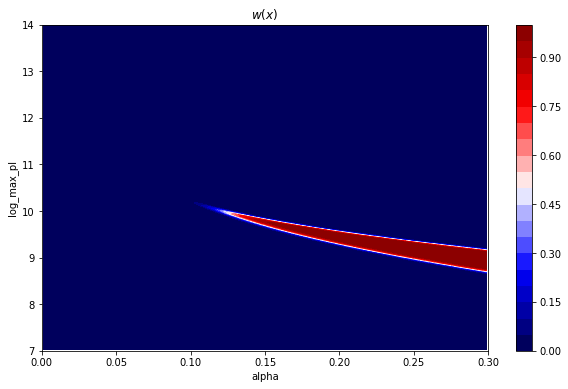

In [177]:
plot_field(fn_np, r'$w(x)$', save='result.pdf')

In [212]:
df = df.iloc[0:8,0:3]

In [217]:
df["1-w"] = 1
df["w"] = 1
for label, idx in mapping.items():
    d = X[Y==label]
    wd = fn_np(d)
    df.loc[df.index[idx],"w"] = np.mean(wd)
    df.loc[df.index[idx],"1-w"] = 1-np.mean(wd)
    df.loc[df.index[idx],"min w"] = np.min(wd)
    df.loc[df.index[idx],"max w"] = np.max(wd)
df

Total          N   N/Total       1-w         w  \
B⁺→K⁺J/ψ(→ee)    2084124.0   731925.0  0.351191  0.991828  0.008172   
B⁺→K⁺J/ψ(→µµ)    3206889.0  1460434.0  0.455405  1.000000  1.000000   
B⁺→K⁺ee           413741.0    36689.0  0.088676  0.933595  0.066405   
B⁺→K⁺µµ           665455.0    72527.0  0.108989  1.000000  1.000000   
B⁺→K⁺ψ(2S)(→ee)   869415.0   247181.0  0.284307  0.991827  0.008173   
B⁺→K⁺ψ(2S)(→µµ)  2313029.0  1039105.0  0.449240  1.000000  1.000000   
D⁺→π⁺φ(→ee)       499520.0   149292.0  0.298871  0.991874  0.008126   
D⁺→π⁺φ(→µµ)       678441.0   312775.0  0.461020  1.000000  1.000000   

                        min w     max w  
B⁺→K⁺J/ψ(→ee)    5.346351e-08  0.999995  
B⁺→K⁺J/ψ(→µµ)             NaN       NaN  
B⁺→K⁺ee          6.535834e-23  1.000000  
B⁺→K⁺µµ                   NaN       NaN  
B⁺→K⁺ψ(2S)(→ee)  3.951005e-03  0.008772  
B⁺→K⁺ψ(2S)(→µµ)           NaN       NaN  
D⁺→π⁺φ(→ee)      1.401298e-44  0.999997  
D⁺→π⁺φ(→µµ)               NaN       NaN

In [218]:
double_ratio(df["1-w"]), double_ratio_psi2S(df["1-w"])

(1.0623744892903115, 1.0000006009579174)

In [223]:
1/double_ratio(df["1-w"]), 1/double_ratio_psi2S(df["1-w"])

(0.9412876627600697, 0.9999993990424437)

In [219]:
double_ratio(df["w"]), double_ratio_psi2S(df["w"])

(0.12306572015792326, 0.9999270689097384)

In [222]:
1/double_ratio(df["w"]), 1/double_ratio_psi2S(df["w"])

(8.125739635023926, 1.0000729364095935)